In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data
---

fetch the data

In [50]:
wb_data = {
    "dwarf" : open("data/worldbox/dwarf").read().splitlines(),
    "elf"   :   open("data/worldbox/elf").read().splitlines(),
    "orc"   :   open("data/worldbox/orc").read().splitlines()
}

xn_data = {
    "dwarf"      : list(set(open("data/xanathar/dwarf_male.txt").read().splitlines()    + open("data/xanathar/dwarf_female.txt").read().splitlines()    + open("data/fantasynamegen/dwarf").read().splitlines())),
    "elf"        : list(set(open("data/xanathar/elf_male.txt").read().splitlines()      + open("data/xanathar/elf_female.txt").read().splitlines()      + open("data/fantasynamegen/elf").read().splitlines())),
    "orc"        : list(set(open("data/xanathar/halforc_male.txt").read().splitlines()  + open("data/xanathar/halforc_female.txt").read().splitlines()  + open("data/fantasynamegen/orc").read().splitlines())),
    "tiefling"   : list(set(open("data/xanathar/tiefling_male.txt").read().splitlines() + open("data/xanathar/tiefling_female.txt").read().splitlines() + open("data/fantasynamegen/tiefling").read().splitlines())),
    "halfling"   : list(set(open("data/xanathar/halfling_male.txt").read().splitlines() + open("data/xanathar/halfling_female.txt").read().splitlines() + open("data/fantasynamegen/halfling").read().splitlines())),
    "dragonborn" : list(set(open("data/xanathar/halfling_male.txt").read().splitlines() + open("data/xanathar/halfling_female.txt").read().splitlines() + open("data/fantasynamegen/dragonborn").read().splitlines()))
}


print("total worldbox data : ", sum(len(d) for d in wb_data.values()))
print("max worldbox data : ", max(len(p) for d in wb_data.values() for p in d))


total worldbox data :  4412
max worldbox data :  12


clean data

In [51]:
for i in xn_data.keys():
    xn_data[i] = list(set(d.strip().lower() for d in xn_data[i]))


stoi = { s:i for i,s in enumerate(list(p for d in xn_data.values() for p in d)) }
itos = { i:s for s,i in stoi.items()}

label_stoi = {s:i for i,s in enumerate(list(xn_data.keys()))}
label_itos = {s:i for i,s in label_stoi.items()}


# print(len(set(p for d in xn_data.values() for p in d)))

my_dict = {i:list(p for d in xn_data.values() for p in d).count(i) for i in list(p for d in xn_data.values() for p in d)   }


print(len(list(stoi.items())))
print("total xanathar data : ", sum(len(d) for d in xn_data.values()) )


6184
total xanathar data :  6329


In [52]:
label_stoi

{'dwarf': 0, 'elf': 1, 'orc': 2, 'tiefling': 3, 'halfling': 4, 'dragonborn': 5}

In [53]:
max(len(p) for d in xn_data.values() for p in d for c in p)

18

In [54]:
def charsplit(s:str, pad=18):
    return [ord(d)-ord('a')+1.0 for d in s] + ([0] * (pad-len(s)))

charsplit("abcdefg")

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [55]:

Xtr, Ytr = list(charsplit(p) for d in xn_data.values() for p in d), list(label_stoi[p] for d in xn_data.keys() for p in [d]*len(xn_data[d]))
Xtr = torch.tensor(Xtr)
Ytr = torch.tensor(Ytr)
len(Xtr), len(Ytr)

(6329, 6329)

In [56]:
# only with no stoi[p] and label_stoi[p] in Xtr,Ytr definition
# check = {"dwarf":[], "elf":[], "orc":[], "tiefling":[], "halfling":[]}
# for i in zip(Ytr,Xtr):
#     check[i[0]].append(i[1])
# 
# #xn_data == check
# print(Xtr[191], Ytr[440])
# 
# for i in range(len(Xtr)):
#     if Xtr[i] == 'nora':
#         print(i)

Xtr.dtype

torch.float32

### Making the model
---

In [86]:
model = torch.nn.Sequential(
    torch.nn.Linear(18 , 300) ,    
    torch.nn.Linear(300,  100),  torch.nn.BatchNorm1d(100) ,torch.nn.Tanh(),
    torch.nn.Linear(100 , 100),  torch.nn.BatchNorm1d(100) ,torch.nn.Tanh(),
    torch.nn.Linear(100 , 50) ,  torch.nn.BatchNorm1d(50)  ,torch.nn.Tanh(),
    torch.nn.Linear(50 , 6) 
)

with torch.no_grad():
    list(model.modules())[-1].weight *= 0.1

for n in model.parameters():
    n.requires_grad = True

parameters = model.parameters()
sum(p.nelement() for p in parameters)

51756

In [90]:

batch_size = 32
epochs = 200000
lossi = []

for i in range(epochs):
    ix = torch.randint(0, 6329, (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #emb = 
    #X = torch.randn((32,12))dk
    logits = model(Xb)
    #l1 = torch.tanh(Xb @ W1 + b1)
    #l2 = torch.tanh(l1 @ W2 + b2)
    #logits = l2 @ W3 + b3

    loss = F.cross_entropy(logits, Yb)

    if i % 100 == 0:
        print(loss.item())

    for p in model.parameters():
        p.grad = None
    loss.backward()

    lr = 0.1 if (i < epochs*0.8) else 0.01

    for p in model.parameters():
        p.data += -lr * p.grad 

    lossi.append(loss.item())


1.4581159353256226
1.462712049484253
1.505133032798767
1.387468695640564
1.323065161705017
1.3776267766952515
1.0554686784744263
1.394513726234436
1.3672699928283691
1.127171277999878
1.4042222499847412
1.2824525833129883
1.1012556552886963
1.0633513927459717
1.0477932691574097
1.2640681266784668
1.2904751300811768
1.3355910778045654
1.3015494346618652
1.2745524644851685
1.312493920326233
1.3115530014038086
1.353153109550476
0.9562774300575256
0.9720226526260376
1.035566806793213
1.0828148126602173
1.0451545715332031
1.1500868797302246
1.3233212232589722
1.2715694904327393
1.349629521369934
1.246604323387146
1.0077871084213257
1.1093837022781372
1.1723359823226929
1.3940131664276123
1.0683048963546753
1.2715139389038086
1.2011582851409912
0.9326258301734924
1.1818145513534546
1.5477135181427002
1.0581532716751099
1.2457575798034668
1.3424826860427856
1.4035780429840088
0.8798241019248962
1.1102832555770874
1.2293267250061035
0.8414077162742615
1.202601671218872
0.9947544932365417
1.397

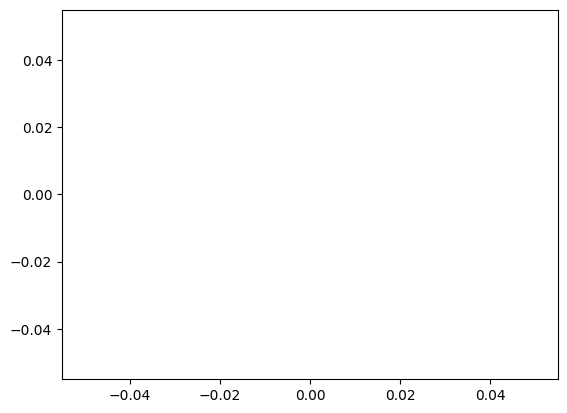

In [88]:
plt.plot(lossi)

In [58]:
W1 = torch.randn((18, 300))
b1 = torch.randn(300)
W2 = torch.randn((300,100))
b2 = torch.randn(100)
W3 = torch.randn((100,6))
b3 = torch.randn(6)

parameters = [W1,b1,W2,b2,W3,b3]
for p in parameters:
    p.requires_grad = True

In [33]:
batch_size = 32
epochs = 200000

for i in range(epochs):
    ix = torch.randint(0, 6329, (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #emb = 
    #X = torch.randn((32,12))dk
    l1 = torch.tanh(Xb @ W1 + b1)
    l2 = torch.tanh(l1 @ W2 + b2)
    logits = l2 @ W3 + b3

    loss = F.cross_entropy(logits, Yb)

    if i % 100 == 0:
        print(loss.item())

    for i in parameters:
        i.grad = None

    loss.backward()

    lr = 0.1 if i < epochs*0.8 else 0.01

    for i in parameters:
        i.data += -lr * i.grad 

    lossi.append(loss.item())



8.783212661743164
5.889493942260742
5.292472839355469
4.661529541015625
3.373735189437866
2.446441888809204
3.2106518745422363
2.185859441757202
2.9625046253204346
2.1593596935272217
2.363807201385498
2.4759819507598877
2.1296627521514893
2.3696932792663574
2.6975157260894775
2.1817429065704346
2.1647238731384277
2.116429090499878
2.1723973751068115
1.95066237449646
2.3403592109680176
2.065032482147217
1.8949111700057983
1.544066071510315
1.9038382768630981
1.8761043548583984
2.113426923751831
1.5974210500717163
1.9701080322265625
1.8634363412857056
1.9722572565078735
1.6429522037506104
2.162642478942871
1.7998661994934082
1.6669085025787354
1.9511784315109253
1.7174938917160034
1.9627491235733032
1.5466710329055786
1.5971633195877075
1.6543517112731934
1.7290068864822388
1.4984040260314941
1.9609103202819824
1.8377277851104736
1.2720203399658203
1.554226279258728
1.411172866821289
1.7416491508483887
1.888405680656433
1.3872309923171997
1.7220866680145264
1.5531370639801025
1.777251958

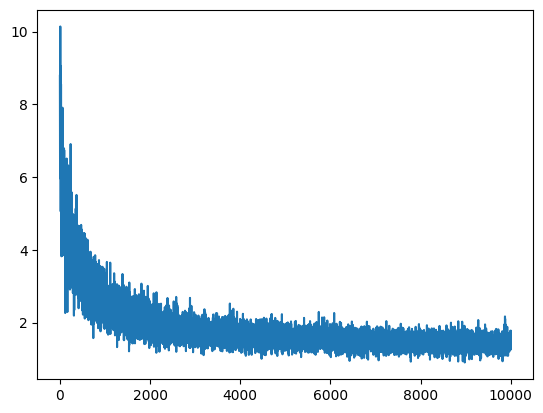

In [34]:
plt.plot(lossi)

In [35]:
# test data
testing = [d.split(",") for d in open("data/testdata").read().splitlines()]
tX, tY = [charsplit(d[0].split(" ")[0]) for d in testing], [label_stoi[d[1].lower()] for d in testing]
tX = torch.tensor(tX)
tY = torch.tensor(tY)


l1 = torch.tanh(tX @ W1 + b1)
l2 = torch.tanh(l1 @ W2 + b2)
logits = l2 @ W3 + b3
loss = F.cross_entropy(logits, tY)
loss

tensor(4.5954, grad_fn=<NllLossBackward0>)

tensor(5.4475, grad_fn=<NllLossBackward0>)

In [48]:
prompt = "nathaniel okunwobi"
prompt = charsplit(prompt)
prompt = torch.tensor(prompt)


l1 = torch.tanh(prompt @ W1 + b1)
l2 = torch.tanh(l1 @ W2 + b2)
logits = l2 @ W3 + b3
probs = F.softmax(logits, dim=0)
print(probs.data)

tensor([4.4724e-06, 1.3809e-04, 5.4434e-03, 5.2593e-05, 5.7913e-02, 9.3645e-01])


In [114]:
label_stoi

{'dwarf': 0, 'elf': 1, 'orc': 2, 'tiefling': 3, 'halfling': 4, 'dragonborn': 5}

SyntaxError: unterminated string literal (detected at line 2) (589144943.py, line 2)